In [96]:
# NLP
import spacy

# EDA Packages
import pandas as pd
import numpy as np

# Visualisation packages.
import matplotlib.pyplot as plt
import seaborn as sns

# Counting Words
import string
import re
from collections import Counter

In [97]:
# Read the Ceneo Scraper Output
df = pd.read_csv("./data/output.csv", low_memory=False)

In [98]:
# Data types are mixed
# There are multiple Nan values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69118 entries, 0 to 69117
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   entry_date     61217 non-null  object
 1   entry_id       61217 non-null  object
 2   full_category  61217 non-null  object
 3   offer_ref      69118 non-null  object
 4   product_title  61217 non-null  object
 5   purchase_date  60845 non-null  object
 6   review_text    61214 non-null  object
 7   score          61217 non-null  object
 8   top_category   61217 non-null  object
dtypes: object(9)
memory usage: 4.7+ MB


In [99]:
# "review_text" nan are to be deleted. Other can stay.
df = df.dropna(subset=["review_text"])

In [100]:
# There are invalid entries that resulted from running scraper multiple times.
df.loc[df["entry_date"] == "entry_date"].head()

,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category
1560,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category
6529,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category
10546,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category
14585,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category
18622,entry_date,entry_id,full_category,offer_ref,product_title,purchase_date,review_text,score,top_category


In [101]:
# Remove invalid entries
df = df.loc[df["entry_date"] != "entry_date"]

In [102]:
# fix data types
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["entry_id"] = df["entry_id"].astype(int)
df["offer_ref"] = df["offer_ref"].astype(int)
df["score"] = df["score"].astype(float)

In [103]:
# Get Sentiment Cases based on score
df["sentiment"] = df["score"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

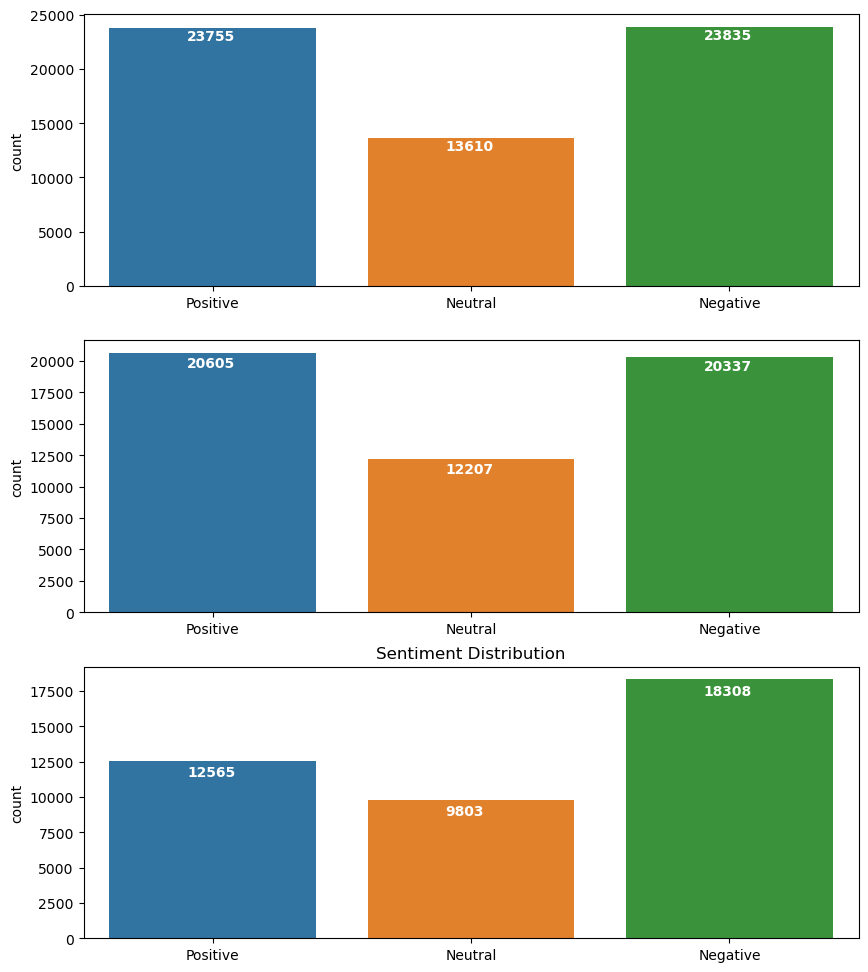

In [104]:
def show_sentiment_count(df, ax=None):

    # Plot Sentiment Distribution
    sns.countplot(x = df["sentiment"].values, order=["Positive", "Neutral", "Negative"], ax=ax)

    # Shouw counts on bars
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height() - 1100), fontsize=10, color='white', weight='bold')

    plt.title("Sentiment Distribution")

# Plot most common words by rating
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

show_sentiment_count(df, ax[0])

df = df.drop_duplicates(["offer_ref", "entry_id", "review_text"])

show_sentiment_count(df, ax[1])

show_sentiment_count(df.drop_duplicates("review_text"), ax[2])

plt.show()

In [105]:
df["review_text"] = df["review_text"].replace("\n", " ", regex=True).replace("_+", " ", regex=True)

In [106]:
with open("./data/polish.stopwords.txt", "r") as f:
    stopwords = f.read().splitlines()
    f.close()

In [107]:
# Grouped by rating: join all review texts into one string
joined_texts = df.groupby("sentiment")[["review_text"]].agg(" ".join)

In [110]:
string.punctuation += "\r\n\t"

In [111]:
# Turn String into a list of words and remove stopwords and punctuation
joined_texts = joined_texts["review_text"].str.split(" ").transform(lambda x: [re.sub(f"[{string.punctuation}0-9]", "", word.lower()) for word in x if word not in stopwords and word not in string.punctuation])
joined_texts = joined_texts.transform(lambda x: [word for word in x if word != ""])

In [112]:
most_common_words_by_rating = joined_texts.transform(lambda x: pd.Series(Counter(x).most_common(20)))

In [113]:
most_common_words_by_rating

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sentiment,,,,,,,,,,,,,,,,,,,,
Negative,"(nie, 5741)","(polecam, 3488)","(niestety, 2254)","(produkt, 2192)","(po, 1844)","(w, 1456)","(brak, 1175)","(produktu, 1152)","(działa, 1149)","(ok, 1118)","(jakość, 1067)","(na, 952)","(zapach, 946)","(to, 937)","(wiem, 868)","(słuchawki, 860)","(raz, 821)","(bardzo, 795)","(się, 735)","(kupiłem, 697)"
Neutral,"(ok, 2090)","(nie, 1105)","(niestety, 918)","(produkt, 909)","(dobry, 698)","(polecam, 695)","(zapach, 585)","(jakość, 566)","(w, 509)","(działa, 506)","(trochę, 492)","(brak, 464)","(bardzo, 447)","(na, 425)","(słuchawki, 419)","(po, 418)","(jest, 415)","(cena, 414)","(dobra, 387)","(wiem, 374)"
Positive,"(polecam, 3318)","(super, 2526)","(ok, 2219)","(bardzo, 1863)","(produkt, 1499)","(dobry, 1333)","(dobra, 762)","(jakość, 759)","(działa, 621)","(jest, 493)","(cena, 468)","(nie, 449)","(zadowolona, 435)","(zapach, 434)","(spełnia, 429)","(cenie, 401)","(w, 396)","(jakości, 391)","(jestem, 384)","(dobre, 382)"


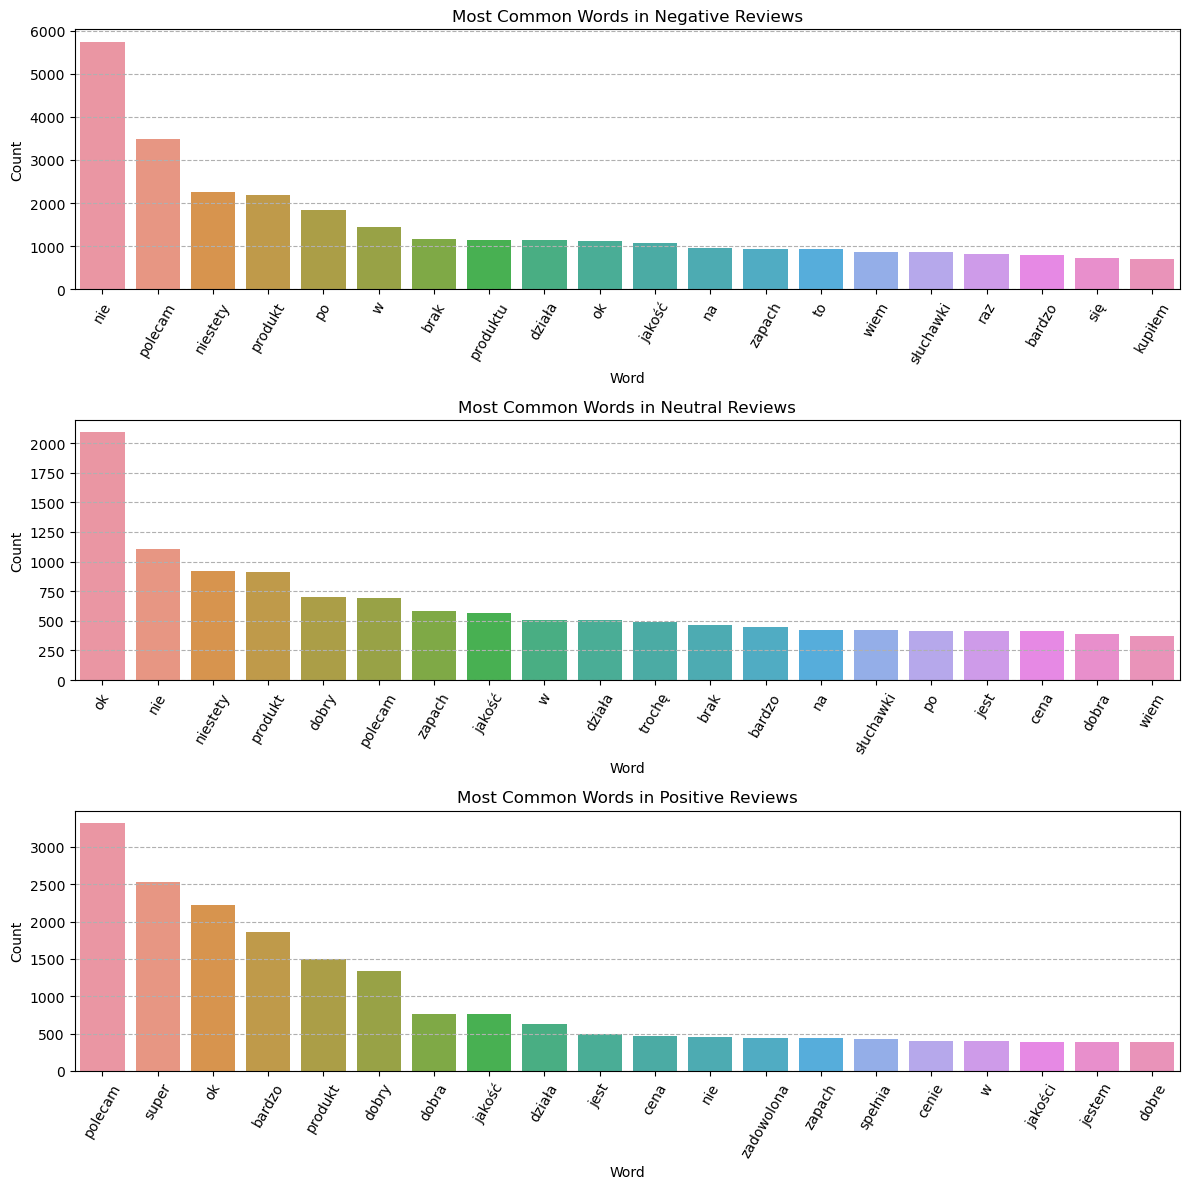

In [114]:
# Plot most common words by rating
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# For each sentiment
for i, sentiment in enumerate(joined_texts.index):
    # Get bar plot where y are count values sourced from [1] position at a tuple.
    # and x are words sourced from [0] position at a tuple.
    sns.barplot(x=most_common_words_by_rating.loc[sentiment].transform(lambda x: x[0]), y=most_common_words_by_rating.loc[sentiment].transform(lambda x: x[1]), ax=ax[i])
    
    # Aesthetics
    ax[i].set_title(f"Most Common Words in {sentiment} Reviews")
    ax[i].set_xlabel("Word")
    ax[i].set_ylabel("Count")
    ax[i].grid(axis="y", linestyle="--")

    # Rotate x labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(60)


plt.tight_layout()
# plt.savefig("./images/most_common_words_by_rating.png")
plt.show()

In [115]:
# Load Large Polish Language Model
nlp = spacy.load("pl_core_news_lg")

In [116]:
df["review_text_tokenized"] = df["review_text"].apply(lambda x: nlp(x))

In [120]:
df["review_text_tokenized"]

0                                                   (😑, 😑)
1        (Lekkie, i, jak, jesteś, na, kuligu, to, szypk...
2        (Niestety, ,, zamiast, opony, otrzymałam, ping...
3                  (Mogły, być, estetyczniej, wykonane, .)
4                                          (Bardzo, dobry)
                               ...                        
69113                      (Jestem, bardzo, zadowolona, .)
69114    (Witam, polecam, sprzedawcę, tranzakcja, szybk...
69115                                                (Git)
69116                                            (Polecam)
69117                              (Jakość, bardzo, dobra)
Name: review_text_tokenized, Length: 53149, dtype: object

In [130]:
df["review_text_tokenized"].apply(lambda x: np.array([token.vector for token in x]))